In [2]:
from __future__ import print_function

import numpy as np
#import reflexxes
import random
import pandas as pd
from numpy import genfromtxt

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances
import datetime

import pickle

In [3]:
# load  clean data

# load noisy data
org_p = np.loadtxt('../Trajectory/data0503/original_position_list.csv', delimiter=' ')
org_v = np.loadtxt('../Trajectory/data0503/original_velocity_list.csv', delimiter=' ')
nos_p_01 = np.loadtxt('../Trajectory/data0503/position_noise_0.1.csv', delimiter=' ')
nos_p_1 = np.loadtxt('../Trajectory/data0503/position_noise_1.csv', delimiter=' ')
nos_p_2 = np.loadtxt('../Trajectory/data0503/position_noise_2.csv', delimiter=' ')
nos_p_5 = np.loadtxt('../Trajectory/data0503/position_noise_5.csv', delimiter=' ')

traj_lens = np.loadtxt('../Trajectory/data0503/traj_lens.csv', delimiter=' ')
traj_lens = traj_lens.astype(int)

In [5]:
# reframe dataset as per traj_lens
traj_lens_cumsum = traj_lens.cumsum()
traj_lens_cumsum = np.delete(traj_lens_cumsum, len(traj_lens_cumsum) - 1)

org_p_spl = np.split(org_p, traj_lens_cumsum, axis=0)
org_v_spl = np.split(org_v, traj_lens_cumsum, axis=0)
nos_p_01_spl = np.split(nos_p_01, traj_lens_cumsum, axis=0)
nos_p_1_spl = np.split(nos_p_1, traj_lens_cumsum, axis=0)
nos_p_2_spl = np.split(nos_p_2, traj_lens_cumsum, axis=0)
nos_p_5_spl = np.split(nos_p_5, traj_lens_cumsum, axis=0)

print(f'org_p.size: {len(org_p_spl)}')
print(f'org_v.size: {len(org_v_spl)}')
print(f'nos_p_01_spl.size: {len(nos_p_01_spl)}')
print(f'nos_p_1_spl.size: {len(nos_p_1_spl)}')
print(f'nos_p_2_spl.size: {len(nos_p_2_spl)}')
print(f'nos_p_5_spl.size: {len(nos_p_5_spl)}')

org_p.size: 100
org_v.size: 100
nos_p_01_spl.size: 100
nos_p_1_spl.size: 100
nos_p_2_spl.size: 100
nos_p_5_spl.size: 100


In [6]:
# plot data function
def on_key_press(event):
    if event.key == 'escape':
        plt.close()
        
def original_plot(x, dd, dddx):
    t = np.linspace(0, len(x) * gen.cycle_time, len(x))
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    ax1.plot(t, x)
    ax1.set_ylabel('position')
    ax1.legend('123', title='DOF #')
    ax2.plot(t, dx)
    ax2.set_ylabel('velocity')
    ax2.legend('123', title='DOF #')
    ax3.plot(t, ddx)
    ax3.set_ylabel('acceleration')
    ax3.legend('123', title='DOF #')
    ax3.set_xlabel('time')
    plt.show()
    
def plot_trajectory(x, title):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    ax.plot3D(xline, yline, zline, 'green')

In [ ]:
# plot 1st trajectory 
plot_trajectory(nos_p_1, 'all noise')
plot_trajectory(org_p_spl[0], '1st Original Trajectory')
plot_trajectory(nos_p_01_spl[0], '1st Noise Trajectory 0.1')
plot_trajectory(nos_p_1_spl[0], '1st Noise Trajectory 1')
plot_trajectory(nos_p_2_spl[0], '1st Noise Trajectory 2')
plot_trajectory(nos_p_5_spl[0], '1st Noise Trajectory 5')

In [18]:
# concat positions and velocity by columns 
full_data = []
for i in range(len(nos_p_1_spl)):
    full_data.append(np.concatenate((nos_p_1_spl[i],org_v_spl[i]),axis=1))

# print(full_data[0][0:10])
# print(nos_p_1_spl[0][0:10])
# print(org_v_spl[0][0:10])

In [43]:
# try label no. = 10

init_mean_pos = []

# Hui Min CHANGE ME~~ : number of component in each diagonal
num = 5 

for i in range(num):
    for j in range(num):
        for k in range(num):
            init_mean_pos.append([i * (100/num) + (50/num), j * (100/num) + (50/num), k * (100/num) + (50/num)])

# initialize velocity means to 0
init_mean_vel = np.zeros((num**3,3))
init_mean = np.concatenate((np.array(init_mean_pos),init_mean_vel),axis=1)
print(init_mean)   

[[10. 10. 10.  0.  0.  0.]
 [10. 10. 30.  0.  0.  0.]
 [10. 10. 50.  0.  0.  0.]
 [10. 10. 70.  0.  0.  0.]
 [10. 10. 90.  0.  0.  0.]
 [10. 30. 10.  0.  0.  0.]
 [10. 30. 30.  0.  0.  0.]
 [10. 30. 50.  0.  0.  0.]
 [10. 30. 70.  0.  0.  0.]
 [10. 30. 90.  0.  0.  0.]
 [10. 50. 10.  0.  0.  0.]
 [10. 50. 30.  0.  0.  0.]
 [10. 50. 50.  0.  0.  0.]
 [10. 50. 70.  0.  0.  0.]
 [10. 50. 90.  0.  0.  0.]
 [10. 70. 10.  0.  0.  0.]
 [10. 70. 30.  0.  0.  0.]
 [10. 70. 50.  0.  0.  0.]
 [10. 70. 70.  0.  0.  0.]
 [10. 70. 90.  0.  0.  0.]
 [10. 90. 10.  0.  0.  0.]
 [10. 90. 30.  0.  0.  0.]
 [10. 90. 50.  0.  0.  0.]
 [10. 90. 70.  0.  0.  0.]
 [10. 90. 90.  0.  0.  0.]
 [30. 10. 10.  0.  0.  0.]
 [30. 10. 30.  0.  0.  0.]
 [30. 10. 50.  0.  0.  0.]
 [30. 10. 70.  0.  0.  0.]
 [30. 10. 90.  0.  0.  0.]
 [30. 30. 10.  0.  0.  0.]
 [30. 30. 30.  0.  0.  0.]
 [30. 30. 50.  0.  0.  0.]
 [30. 30. 70.  0.  0.  0.]
 [30. 30. 90.  0.  0.  0.]
 [30. 50. 10.  0.  0.  0.]
 [30. 50. 30.  0.  0.  0.]
 

In [60]:
final_data = full_data[0]
for i in range(1,len(full_data)):
    final_data = np.concatenate((final_data, full_data[i]))

In [61]:
final_data.shape

(65900, 6)

In [62]:
a = datetime.datetime.now()
HMM_10 = hmm.GaussianHMM(n_components=num**3, covariance_type="spherical", init_params="sct", params="sct", n_iter=200, verbose=True)
HMM_10.means_ = init_mean

# fit data: change me (org_p) to nos_p_01
HMM_10.fit(np.array(final_data), traj_lens)
b = datetime.datetime.now()
print(b-a)

         1    -1565821.7135             +nan
         2    -1326943.6712     +238878.0423
         3    -1276760.2187      +50183.4525
         4    -1269762.2280       +6997.9907
         5    -1269318.1814        +444.0466
         6    -1269243.4870         +74.6944
         7    -1269195.3649         +48.1221
         8    -1269169.3164         +26.0485
         9    -1269144.4434         +24.8729
        10    -1269134.2730         +10.1704
        11    -1269130.9744          +3.2986
        12    -1269127.7139          +3.2605
        13    -1269124.7900          +2.9239
        14    -1269124.1264          +0.6636
        15    -1269122.7721          +1.3543
        16    -1269115.6475          +7.1246
        17    -1269115.4647          +0.1828


1:11:13.997222


        18    -1269115.4607          +0.0040


In [ ]:
# plot means
plot_trajectory(HMM_10.means_, 'HMM10_mean')
#print(HMM_10.means_)

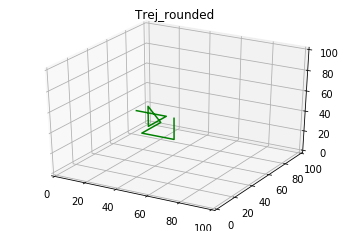

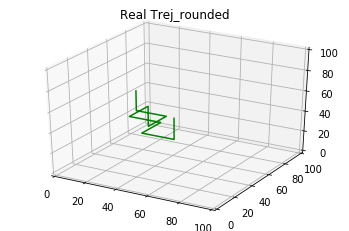

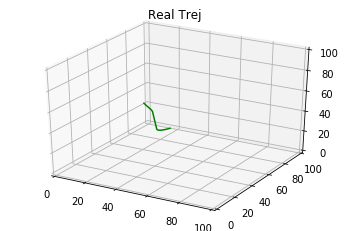

In [64]:
select_traj = 0

# load noise data for predict
replace = full_data[select_traj] 
# load clean data for comparison
real= org_p_spl[select_traj]    

pred = HMM_10.predict(replace)

# only take means for pos 
pos_means = HMM_10.means_[:,0:3]

orig_rd = np.ceil(real/20)*20-10
trej_rd = []
trej = []

for point in pred:
    trej_rd.append(np.ceil(pos_means[point]/20)*20-10)
plot_trajectory(trej_rd, 'Trej_rounded')
plot_trajectory(orig_rd, 'Real Trej_rounded')

for point in pred:
    trej.append(HMM_10.means_[point])
#plot_trajectory(trej, 'Trej')
plot_trajectory(real, 'Real Trej')

In [ ]:
#plot_trajectory(org_p, 'all data') # overall data

In [67]:
# Accuracy (%)
traj = real
labels = np.zeros(len(traj))

def closest_node(node,nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2,axis=1)
    return np.argmin(dist_2)

for i,data in enumerate(traj):
    labels[i] = closest_node(data,init_mean_pos)

print("model accuracy is: ", np.mean(labels == pred))

model accuracy is:  0.9549763033175356


In [63]:
# export model

with open("May03_5x5x5_noise1_WITH_velocity.pkl", "wb") as file: pickle.dump(HMM_10, file)
# use below to import   
#with open("filename.pkl", "rb") as file: HMM_10 = pickle.load(file)
